In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression



In [4]:
df = pd.read_csv('jamb_exam_results.csv')
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [6]:
del df['student_id']

In [7]:
df.isnull().sum()

jamb_score                        0
study_hours_per_week              0
attendance_rate                   0
teacher_quality                   0
distance_to_school                0
school_type                       0
school_location                   0
extra_tutorials                   0
access_to_learning_materials      0
parent_involvement                0
it_knowledge                      0
age                               0
gender                            0
socioeconomic_status              0
parent_education_level          891
assignments_completed             0
dtype: int64

In [8]:
df['parent_education_level'].fillna(0, inplace=True)

/tmp/ipykernel_31700/3606112004.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['parent_education_level'].fillna(0, inplace=True)


In [9]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values

del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']

# categorical = ['school_type', 'parent_education_level', 'home']
# numerical = ['age', 'study_time', 'failures', 'absences']


In [10]:
dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(dicts)


In [11]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [12]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=1)

In [13]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = dt.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
print('train MSE:', mse)
print('train R²:', r2)

y_pred = dt.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print('val MSE:', mse)
print('val R²:', r2)

train MSE: 1938.9823793038152
train R²: 0.12513546804009779
val MSE: 2097.947700941875
val R²: 0.09495627999810752


### Question 1

In [14]:
from sklearn.tree import export_text

print(export_text(dt, feature_names=list(dv.get_feature_names_out())))



|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



### Question 2

In [15]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)
print('val RMSE:', rmse)
print('val MSE:', mse)
print('val R²:', r2)


val RMSE: 42.13724207871227
val MSE: 1775.5471699999998
val R²: 0.23403819120267289


In [16]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n,
                                random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)
    # print('val RMSE:', rmse)
    # print('val MSE:', mse)
    # print('val R²:', r2)
    scores.append((n, rmse))



In [17]:
columns = ['n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns).round(3)
df_scores.sort_values(by='rmse', ascending=True).head()

,n_estimators,rmse
8,90,40.504
9,100,40.517
7,80,40.539
10,110,40.593
13,140,40.595


### Question 3

<Axes: xlabel='n_estimators', ylabel='rmse'>

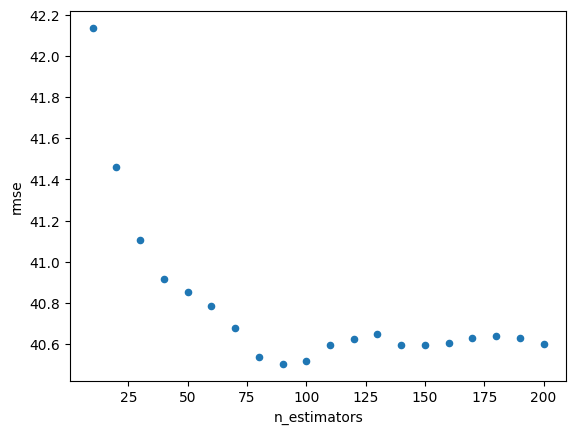

In [18]:
df_scores.plot(x='n_estimators', y='rmse', kind='scatter')


In [19]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val, y_pred)
        # print('val RMSE:', rmse)
        # print('val MSE:', mse)
        # print('val R²:', r2)
        scores.append((n, d, rmse))

### Question 4

In [20]:
columns = ['n_estimators', 'max_depth', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns).round(3)



In [21]:
df_scores.groupby('max_depth').agg({'rmse': 'mean'}).reset_index().sort_values(by='rmse', ascending=True)

,max_depth,rmse
0,10,40.39240
1,15,40.73535
2,20,40.73970
3,25,40.78785


In [22]:
df_train.columns

Index(['study_hours_per_week', 'attendance_rate', 'teacher_quality',
       'distance_to_school', 'school_type', 'school_location',
       'extra_tutorials', 'access_to_learning_materials', 'parent_involvement',
       'it_knowledge', 'age', 'gender', 'socioeconomic_status',
       'parent_education_level', 'assignments_completed'],
      dtype='object')

### Question 5

In [26]:
rf = RandomForestRegressor(n_estimators=10, n_jobs=-1, max_depth=20, random_state=1)
rf.fit(X_train, y_train)

feature_names = dv.get_feature_names_out()
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf.feature_importances_
})
print(feature_importance.sort_values(by='importance', ascending=False))



                             feature  importance
27              study_hours_per_week    0.248354
4                    attendance_rate    0.149729
5                 distance_to_school    0.136486
28                   teacher_quality    0.082682
2                                age    0.069311
3              assignments_completed    0.031517
24         socioeconomic_status=High    0.025714
17           parent_involvement=High    0.022919
10                 it_knowledge=High    0.017719
15  parent_education_level=Secondary    0.016957
14    parent_education_level=Primary    0.015450
16   parent_education_level=Tertiary    0.014489
6                 extra_tutorials=No    0.013459
18            parent_involvement=Low    0.013358
11                  it_knowledge=Low    0.012404
0    access_to_learning_materials=No    0.012325
19         parent_involvement=Medium    0.011492
25          socioeconomic_status=Low    0.010708
26       socioeconomic_status=Medium    0.010563
9                   

In [27]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [28]:
watchlist = [(dtrain, 'train'), (dval, 'val')]


In [29]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-rmse:42.69384	val-rmse:44.89114
[5]	train-rmse:34.57756	val-rmse:40.69096
[10]	train-rmse:31.63404	val-rmse:40.48319
[15]	train-rmse:29.41497	val-rmse:40.86107
[20]	train-rmse:27.49658	val-rmse:41.27921
[25]	train-rmse:26.34353	val-rmse:41.57975
[30]	train-rmse:24.21076	val-rmse:41.72928
[35]	train-rmse:22.46394	val-rmse:42.03417
[40]	train-rmse:21.35340	val-rmse:42.24363
[45]	train-rmse:20.24355	val-rmse:42.27966
[50]	train-rmse:19.25157	val-rmse:42.43824
[55]	train-rmse:18.28398	val-rmse:42.54750
[60]	train-rmse:17.12178	val-rmse:42.64446
[65]	train-rmse:16.41573	val-rmse:42.77416
[70]	train-rmse:15.78314	val-rmse:42.84909
[75]	train-rmse:14.80007	val-rmse:43.00760
[80]	train-rmse:13.96907	val-rmse:43.08250
[85]	train-rmse:13.39102	val-rmse:43.16297
[90]	train-rmse:12.46485	val-rmse:43.25161
[95]	train-rmse:11.95568	val-rmse:43.37919
[99]	train-rmse:11.39140	val-rmse:43.41882


In [30]:
y_pred = model.predict(dval)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)
print('val RMSE:', rmse)
print('val MSE:', mse)
print('val R²:', r2)


val RMSE: 43.418817345871766
val MSE: 1885.1936997141747
val R²: 0.18673723936080933


In [31]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-rmse:45.49999	val-rmse:47.00533
[5]	train-rmse:40.17514	val-rmse:43.11181
[10]	train-rmse:37.07490	val-rmse:41.39235
[15]	train-rmse:35.08521	val-rmse:40.61341
[20]	train-rmse:33.67389	val-rmse:40.25010
[25]	train-rmse:32.55850	val-rmse:40.12003
[30]	train-rmse:31.76039	val-rmse:40.13806
[35]	train-rmse:31.01425	val-rmse:40.16103
[40]	train-rmse:30.13427	val-rmse:40.17753
[45]	train-rmse:29.49040	val-rmse:40.27366
[50]	train-rmse:28.75947	val-rmse:40.29573
[55]	train-rmse:28.17535	val-rmse:40.40072
[60]	train-rmse:27.77264	val-rmse:40.47477
[65]	train-rmse:27.10119	val-rmse:40.47659
[70]	train-rmse:26.61847	val-rmse:40.55225
[75]	train-rmse:26.21281	val-rmse:40.62564
[80]	train-rmse:25.69135	val-rmse:40.61309
[85]	train-rmse:25.14363	val-rmse:40.66530
[90]	train-rmse:24.60413	val-rmse:40.84708
[95]	train-rmse:24.03404	val-rmse:40.99952
[99]	train-rmse:23.59704	val-rmse:41.05034


In [32]:
y_pred = model.predict(dval)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)
print('val RMSE:', rmse)
print('val MSE:', mse)
print('val R²:', r2)

val RMSE: 41.05034017683498
val MSE: 1685.130428633872
val R²: 0.2730434536933899
